1. Создаем датафрейм с названием фильма, уровнем и названием файла с субтитрами
    * Удаляем лишние столбцы
    * Применяем `.strip()` к названию фильмов (там были переносы строк)
    * Заменяем `/` на `_` в названии уровней для корректной работы path строк.
    * Собираем список файлов с субтитрами с помощью `os.listdir()`
    * С помощью `difflib.get_close_matches()` создаем столбец с названиями файлов субтитров
2. Создадим из каждого субтитра plain text (.txt) с помощью `pysubs2` в отдельной папке
3. Распределим txt по подпапкам с уровнем сложности для корректной работы `sklearn.datasets.load_files`
4. Извлечение мета информации из субтитров (распределение скорости показа, распределение длинны предложений) [**TO DO**]
5. Предобработка словаря
    * Оставим записи с только 1 словом
    * И записи принадлежащие только 1 уровню, а не нескольким сразу (см. раздел)
    1. Удаление спец. символов и цифр `re.sub("(\\W|\\d)","",x)`
    2. Приведение к нижнему регистру `.lower()`
    3. `nltk.stem.WordNetLemmatizer`
6. Ф-ции токенизации и лемматизации текста with `spaCy`
7. Исследование уровней [**ONGOIN**]
8. Пайплайн для тренировки логистической регрессии [**RAW**]
9. Оценка моделей бинарной классификации для каждого уровня [**RAW**]

## Создаем датафрейм с названием фильма, уровнем и названием файла с субтитрами

In [1]:
import warnings
import os
import shutil
import pathlib

import difflib

import numpy as np
import pandas as pd


import pysubs2

import re

import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import Pool, CatBoostClassifier

from sklearn.model_selection import cross_val_score

In [2]:
def labels_preproc(path):
    labels = pd.read_csv(path)
    # labels.columns
    labels = labels.drop(columns=['Kinopoisk ','Subtitles'])
    labels = labels.sort_values('Movie').reset_index(drop=True)

    labels['Movie'] = labels['Movie'].str.strip()

    # with pd.option_context("display.max_rows", 300):
    #     display(labels['Movie'])
    # labels['Movie'].unique()
    # labels['Level'].value_counts()

    labels.loc[labels['Level'] == 'A2/A2+','Level'] = 'A2_A2+'
    # labels.loc[labels['Level'] == 'B1, B2','Level'] = 'A2_A2+'
    labels.loc[labels['Level'] == 'A2/A2+, B1','Level'] = 'A2_A2+, B1'
    return labels

labels = labels_preproc('data/labels.csv')
# labels.head()

In [3]:
def add_subs_file_names(df,path_to_raw_subs):
    # Список уже имеющихся субтитров
    subs_file_list = os.listdir(path_to_raw_subs)
    # subs_file_list = [x.lower() for x in subs_file_list]
    # subs_file_list[:5]
    # labels.head(1)

    # Присваиваем название субтитра по наибольшему совпадению
    for movie in df['Movie']:
        df.loc[df['Movie'] == movie,'sub_file_name'] = difflib.get_close_matches(movie, subs_file_list,cutoff=0)[0]
        
    return df
        
labels = add_subs_file_names(labels,'data/Subtitles_raw/')
labels = labels.drop(index=[39,61]) # Удаляем сериалы
labels.loc[labels['Movie'] == 'Harry Potter (1)', 'sub_file_name'] = 'Harry_Potter_and_the_philosophers_stone(2001).srt'
labels = labels.reset_index(drop=True)

In [4]:

# with pd.option_context("display.max_rows", 300):
#     display(labels)

## Создадим из каждого субтитра plain text (.txt) с помощью `pysubs2` в отдельной папке

Удалить HTML теги просто
https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python#:~:text=If%20you%20need%20to%20strip%20HTML

In [5]:
def create_plain_text_str(sub_file,delete_html_tags=True):
    plain_text = ''
    for line in sub_file:  
        # plain_text += line.plaintext + ' '
        plain_text += line.text + ' '
    
    # Удаление HTML тегов перенесли в предобработку.
    # Нужно помнить, что при открытии файла pysubs2.load
    # keep_html_tags должен быть True
    # if delete_html_tags:
    #     plain_text = re.sub('<[^<]+?>', ' ', plain_text)
        
    return plain_text


# subs = pysubs2.load('data/Subtitles_raw/10_Cloverfield_lane(2016).srt',
#                     # keep_html_tags=False,
#                     keep_unknown_html_tags=True
#                    )

# test = create_plain_text_str(subs)
# test

In [6]:
def create_plain_text_files(df, dir_with_subs,dir_with_txt):
    pwd = os.path.abspath(os.getcwd())
    path_from = os.path.join(pwd, dir_with_subs)
    path_to = os.path.join(pwd, dir_with_txt)
    
    try:
        os.mkdir(path_to)
    except:
        print(dir_with_txt, ' already exists. But that\'s fine')
        
    for i in range(len(labels)):
        
        
        sub_name = labels.iloc[i]['sub_file_name']
        
        path_to_sub_file = os.path.join(path_from,sub_name)
      
        sub_obj = pysubs2.load(path_to_sub_file,keep_html_tags=True)
        
        plain_text = create_plain_text_str(sub_obj)
        
        plain_text_name = sub_name + '.txt'
        # print(plain_text_name)
        path_to_plain_text_file = os.path.join(path_to,plain_text_name)
        
        
        with open(path_to_plain_text_file, "w",encoding="utf-8") as file:
            # Writing data to a file
            file.write(plain_text)
    
# create_plain_text_files(labels, 'data\Subtitles_raw','data\Subtitles_plain_text')

## Распределим txt по подпапкам с уровнем сложности для корректной работы `sklearn.datasets.load_files`

In [7]:
# Это мультклассовая разбивка
# Еще стоит разделить на бинарные задачи

def distribute_into_level_subfolders(labels,dir_with_txt_files,dir_with_level_subfolders):
    pwd = os.path.abspath(os.getcwd())
    path_from = os.path.join(pwd, dir_with_txt_files)
    path_to = os.path.join(pwd, dir_with_level_subfolders)
    # print(path_from)
    # print(path_to)
    
    try:
        os.mkdir(path_to)
    except:
        print(dir_with_level_subfolders, ' already exists. But that\'s fine')
        
    for i in range(len(labels)):
        level = labels.iloc[i]['Level']
        txt_name = labels.iloc[i]['sub_file_name'] + '.txt'
        
        # print(level,txt_name)
        
        path_from_ = os.path.join(path_from,txt_name)
        path_to_level = os.path.join(path_to,level)
        path_to_file = os.path.join(path_to_level,txt_name)

        # print(path_from_)
        # print(path_to_)
        try:
            shutil.copy(path_from_, path_to_file)
        except:
            os.mkdir(path_to_level)
            shutil.copy(path_from_, path_to_file)
    
# distribute_into_level_subfolders(labels,'data\Subtitles_plain_text','data\Subtitles_multiclass')

In [8]:
# Это мульти бинарная разбивка
# Тут столько задач классификации, сколько уровней
# По принципу определения А1 уровень и не А1 уровень
# И так по каждому уровню

def distribute_into_multi_binary_subfolders(labels,dir_with_txt_files,dir_with_multi_binary_subfolders):
    pwd = os.path.abspath(os.getcwd())
    path_from = os.path.join(pwd, dir_with_txt_files)
    path_to = os.path.join(pwd, dir_with_multi_binary_subfolders)
    # print(path_from)
    # print(path_to)
    
#     Создаем папку где будут лежать каждая из классификаций
    try:
        os.mkdir(path_to)
    except:
        print(dir_with_multi_binary_subfolders, ' already exists. But that\'s fine')
    
    for level in labels['Level'].unique():
        
#         Берем уровень

#         Берем субитры этого уровня
        the_level = labels.loc[labels['Level'] == level,'sub_file_name']
        the_level = the_level + '.txt'
        # display(the_level)
        
        # Берем путь до папки где будут располагаться категории
        path_to_level = os.path.join(path_to,level)
        # print(path_to_level)
        
        # Размещаться они будут так:
        #     B1/B1
        #     B1/not_B1
        
        # Пробуем создать папку с категорией контретного уровня 
        try:
            os.mkdir(path_to_level)
        except:
            print(path_to_level, ' already exists. But that\'s fine')        
        
        
        for txt in the_level:
            # Каждый субтитр этого уровня переносим в папку вида B1/B1
            path_from_file = os.path.join(path_from,txt)
            # print(path_from_file)
            path_to_level_level = os.path.join(path_to_level,level)
            path_to_file = os.path.join(path_to_level_level,txt)
            # print(path_to_file)
            try:
                shutil.copy(path_from_file, path_to_file)
            except:
                os.mkdir(path_to_level_level)
                shutil.copy(path_from_file, path_to_file)
            
            # try:
            #     os.mkdir
        
        # Берем субтитры не этого уровня
        not_level = labels.loc[labels['Level'] != level,'sub_file_name']
        not_level = not_level + '.txt'
        
        for txt in not_level:
            # Каждый этот субтитр переносим в папку вида B1/not_B1
            path_from_file = os.path.join(path_from,txt)
            # print(path_from_file)
            path_to_level_level = os.path.join(path_to_level,'not_' + level)
            path_to_file = os.path.join(path_to_level_level,txt)
            # print(path_to_file)    
            
            try:
                shutil.copy(path_from_file, path_to_file)
            except:
                os.mkdir(path_to_level_level)
                shutil.copy(path_from_file, path_to_file)
        
        

    
# distribute_into_multi_binary_subfolders(labels,'data\Subtitles_plain_text','data\Subtitles_multi_binary')

## Извлечение мета информации из субтитров (распределение скорости показа, распределение длинны предложений) `[TO DO]`

Для создания распределения скорости показа нужно время показа субтитра (`end_time - start_time`) разделить на кол-во символов в конкретном субтитре. Делается это с помощью `pysubs2`.

Для создания распределения длинны предложений нужно обработанные субтитры в виде текста (`.txt`) разделить на предложения и посчитать кол-во слов (или напр. кол-во пробелов +1). Эта же процедура позволит посчитать кол-во предложений.

## Предобработка словаря

In [9]:

# vocab = pd.read_json('vocab/worddata.json')
## vocab = pd.json_normalize('vocab/worddata.json')



# vocab
# vocab[vocab['baseword'] == 'and']
# Что такое `'guideword'` и как обрабатывать, что одно слово принадлежит разным уровням?
# vocab['level'].value_counts()

# Нам не нужны уровни выше B2, поэтому обрежем.
# vocab['level'].sort_values().unique().tolist()

# levels = ['A1', 'A2', 'B1', 'B2']

# vocab.loc[vocab['level'].isin(levels)].count()

# vocab = vocab.loc[vocab['level'].isin(levels)]

# vocab
# test = vocab.groupby('baseword')['level'].unique()
# pd.DataFrame(test).head(50)

# with pd.option_context("display.max_rows", 300):
#     display(pd.DataFrame(test))

# stopwords.words('english')

In [10]:
vocab = pd.read_json('vocab/englishprofile.json')
vocab.head()

,baseword,guideword,level,partofspeech,topic,url
0,cattle,None,B1,None,animals,/british-english/words/detail/817
1,clothes,None,A1,None,clothes,/british-english/words/detail/972
2,albeit,None,C2,None,None,/british-english/words/detail/157
3,and,ALSO,A1,None,communication,/british-english/words/detail/229
4,and,AFTER,A1,None,communication,/british-english/words/detail/229


Нам понадобится только `'baseword'` и `'level'`.   
Обратим внимание, что 1 `'baseword'` может принадлежать нескольким уровням.  
1. Сгруппируем по `'baseword'` и возьмем `.unique()` от `'level'`
2. Предобработам `'baseword'`, чтобы в дальнейшем использовать в качестве словаря для `CountVectorizer` и для исследования распределений слов и уровней.
3. Решим как работать со словами, принадлежащими многим уровням

In [11]:
vocab_grouped = pd.DataFrame(vocab.groupby('baseword')['level'].unique())
vocab_grouped = vocab_grouped.reset_index()
vocab_grouped.head()

,baseword,level
0,all along,[B2]
1,all in all,[B2]
2,all of a sudden,[B2]
3,be used to sb/sth/doing sth,[B1]
4,bound to do sth,[B2]


In [12]:
vc = vocab_grouped['level'].value_counts()


In [13]:
vc[:7]

[B2]        2195
[C2]        2085
[B1]        1352
[C1]        1338
[A2]         693
[A1]         326
[B1, B2]       1
Name: level, dtype: int64

Пока будем использовать слова, принадлежащие только 1 уровню, а не многим сразу.

In [14]:
vocab_grouped['level'] = vocab_grouped['level'].apply(lambda x: ''.join(x))
vocab_grouped = vocab_grouped[vocab_grouped['level'].isin(['A1','A2','B1','B2','C1','C2'])]

In [15]:
vocab_grouped

,baseword,level
0,all along,B2
1,all in all,B2
2,all of a sudden,B2
3,be used to sb/sth/doing sth,B1
4,bound to do sth,B2
...,...,...
9757,youth,B1
9758,zebra,B2
9760,zip,B2
9761,zone,B1


In [16]:
vocab_grouped['word_count'] = vocab_grouped['baseword'].str.split().apply(lambda x: len(x))

In [17]:
vocab_grouped.head()

,baseword,level,word_count
0,all along,B2,2
1,all in all,B2,3
2,all of a sudden,B2,4
3,be used to sb/sth/doing sth,B1,5
4,bound to do sth,B2,4


Оставим слова, где только 1 слово.

In [18]:
vocab_grouped = vocab_grouped[vocab_grouped['word_count'] == 1]

In [19]:
vocab_grouped.head()

,baseword,level,word_count
49,Absolutely!,C1,1
51,April,A1,1
52,August,A1,1
53,CD,A1,1
55,CD-ROM,B1,1


Удалим символы и знаки препинания.

In [20]:
vocab_grouped.loc[:,'baseword'] = vocab_grouped['baseword'].apply(lambda x: re.sub("(\\W|\\d)","",x))
vocab_grouped.head()

C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_2576\3102664304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocab_grouped.loc[:,'baseword'] = vocab_grouped['baseword'].apply(lambda x: re.sub("(\\W|\\d)","",x))


,baseword,level,word_count
49,Absolutely,C1,1
51,April,A1,1
52,August,A1,1
53,CD,A1,1
55,CDROM,B1,1


Приведем все к нижнему регистру.

In [21]:
vocab_grouped['baseword'] = vocab_grouped['baseword'].str.lower()

C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_2576\2602915212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocab_grouped['baseword'] = vocab_grouped['baseword'].str.lower()


In [22]:
vocab_grouped.head()

,baseword,level,word_count
49,absolutely,C1,1
51,april,A1,1
52,august,A1,1
53,cd,A1,1
55,cdrom,B1,1


In [23]:
vocab_grouped = vocab_grouped.drop(columns=['word_count']).reset_index(drop=True)

In [24]:
import nltk
import pandas as pd
import re
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

word_net = WordNetLemmatizer() 

vocab_grouped['baseword'] = vocab_grouped['baseword'].apply(lambda x: word_net.lemmatize(x))

In [25]:
vocab_grouped

,baseword,level
0,absolutely,C1
1,april,A1
2,august,A1
3,cd,A1
4,cdrom,B1
...,...,...
4873,youth,B1
4874,zebra,B2
4875,zip,B2
4876,zone,B1


In [26]:
vocab_grouped = vocab_grouped.drop_duplicates()

Создадим словарь в виде списка.

In [27]:
vocab_for_cvect = vocab_grouped['baseword'].unique().tolist()

In [28]:
# vocab_for_cvect

Для обработки словаря мы использовали:
1. Удаление спец. символов и цифр `re.sub("(\\W|\\d)","",x)`
2. Приведение к нижнему регистру `.lower()`
3. `nltk.stem.WordNetLemmatizer`

In [29]:
# Очистим `'baseword'` от самых встречающихся слов.
# cvect = CountVectorizer()
# vocab_string = ' '.join(vocab_grouped.index\
#                         # .apply(str_clean)
#                         # .apply(lemmatize_text)
#                         .unique().tolist())
# vocab_cvect = cvect.fit_transform([vocab_string])
# vocab_cvect = pd.DataFrame(vocab_cvect.toarray(),columns = cvect.get_feature_names_out()).T
# vocab_cvect.sort_values(0,ascending=False).head(50)

## Ф-ции токенизации и лемматизации текста
Для исследования уровней сложности английского языка с помощью словаря нам нужно привести текст в табличный вид.

In [30]:
# =====================
# НЕ ИСПОЛЬЗУЕМ
# =====================
def tokenize_for_wordnet(text:str) -> list:
    
    # Удаляем все html теги
    text = re.sub('<[^<]+?>', ' ', text)

    # Удалим . ? , '
    text = re.sub('(\.|\?|,|\')','',text)
    
    # Удаление оcтальных спец символов и цифр
    text = re.sub("(\\W|\\d)"," ",text)
    
    text = text.lower().split()
    
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
    
# tokenize(test_text)[:1000]

In [31]:
# =====================
# НЕ ИСПОЛЬЗУЕМ
# =====================
def lemmatize_wordnet(token_list) -> list:
    # result = []
    word_net = WordNetLemmatizer() 
    result = [word_net.lemmatize(token) for token in token_list]
    return result

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
    
# token_list =  tokenize(test_text)[:1000]

# lemmatize_wordnet(token_list)

Здесь последовательно 4 функции для токенизации и лемматизации текста с помощью `spaCy`.  
И 5 объединяющая.

In [32]:
def tokenize_for_spacy(text:str) -> str:
    
    # Удаляем все html теги
    text = re.sub('<[^<]+?>', ' ', text)

    # Удалим . ? , '
    # text = re.sub('(\.|\?|,|\')','',text)
    
    # Удалим '
    # text = re.sub('\'','',text)
    
    # Удаление оcтальных спец символов и цифр
    # text = re.sub("(\\W|\\d)"," ",text)
    
    text = text.lower()
    
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()

# test = tokenize_for_spacy(test_text)

In [33]:

def lemmatize_spacy(text:str,spacy_nlp) -> str:
    str_ = spacy_nlp(text)
    result = " ".join([token.lemma_ for token in str_])
    return result


# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
# test = tokenize_for_spacy(test_text)

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# lemmatize_spacy(test,nlp)

In [34]:
def clean_up_for_spacy(text:str) -> str:
    # Удаление оcтальных спец символов и цифр
    text = re.sub("(\\W|\\d)"," ",text)
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
# test = tokenize_for_spacy(test_text)
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# test = lemmatize_spacy(test,nlp)

# clean_up_for_spacy(test)

In [35]:
def final_split(text:str) -> list:
    return text.split()

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
# test = tokenize_for_spacy(test_text)
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# test = lemmatize_spacy(test,nlp)
# test = clean_up_for_spacy(test)

# final_split(test)

In [36]:
def spacy_str_preproc(text,spacy_nlp) -> list:
    text = tokenize_for_spacy(text)
    text = lemmatize_spacy(text,spacy_nlp)
    text = clean_up_for_spacy(text)
    text = final_split(text)
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# spacy_str_preproc(test_text,nlp)

## Исследование уровней `[patrially done]`

Цели:
1. Сравнить распределения кол-ва слов каждого уровня сложности в фильмах с различными таргетами (с помощью словаря)
2. Сравнить длинну предложений в фильмах разного уровня сложности
3. Сравнить скорость показа субтитров -//-
4. Сравнить кол-во слов не попавших в словарь их кол-во уникальных слов (`count` и `nunique`)

In [37]:
pwd = os.path.abspath(os.getcwd())
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

word_level_counts = pd.DataFrame()

for sub_txt_file in labels['sub_file_name']:
    # берем субтитр в виде текста
    # предобрабатываем его 
    # переводим в датафрейм
    # мерджим этот датафрейм со словарем (full outer)
    # группируем по уровню сложности слова и извлекаем count и nunique по baseword
    # то что не имеет уровня сложности относим к словам за его пределами (тоже важная статистика)
    
    
    path_to_sub_txt = os.path.join(pwd, 'data\\Subtitles_plain_text\\')
    path_to_sub_txt = os.path.join(path_to_sub_txt, sub_txt_file + '.txt')
    # print(path_to_sub_txt)
    
    with open(path_to_sub_txt, 'r') as f:
        sub_plain_text = f.read()
        
    sub_bag_of_words = spacy_str_preproc(sub_plain_text,nlp)
    # print(sub_bag_of_words)
    
    sub_bag_of_words = pd.DataFrame(sub_bag_of_words,columns=['baseword'])
    
    sub_bag_of_words = sub_bag_of_words.merge(vocab_grouped,how='left')#left_on=0,right_on='baseword')
    # display(sub_bag_of_words)
    
    
    # Melting и перевод в одну строку, для объединения с labels
    # display(sub_bag_of_words.groupby('level',dropna=False)['baseword'].agg(['count','nunique']))
    # test = sub_bag_of_words.groupby('level',dropna=False)['baseword'].agg(['count','nunique'])
    sub_word_count = sub_bag_of_words.groupby('level',dropna=False)['baseword'].agg(['count','nunique'])
    sub_word_count.index = sub_word_count.index.fillna('not_in_vocab')
    sub_word_count = pd.melt(sub_word_count,value_vars = ['count','nunique'],ignore_index=False)
    sub_word_count = sub_word_count.set_index([sub_word_count.index,sub_word_count['variable']])
    sub_word_count.index = ['_'.join(ind) for ind in sub_word_count.index.values]
    sub_word_count = sub_word_count.drop(columns=['variable']).T
    sub_word_count['sub_file_name'] = sub_txt_file
    word_level_counts = pd.concat([word_level_counts,sub_word_count])
    
    # break
    
word_level_counts = word_level_counts.reset_index(drop=True)
df = labels.merge(word_level_counts)

In [38]:
word_level_counts.head()

,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,not_in_vocab_count,A1_nunique,A2_nunique,B1_nunique,B2_nunique,C1_nunique,C2_nunique,not_in_vocab_nunique,sub_file_name
0,487,328,180,133,17,50,4544,80,73,84,62,13,24,680,10_Cloverfield_lane(2016).srt
1,759,527,243,159,41,53,7393,98,80,114,101,31,38,1096,10_things_I_hate_about_you(1999).srt
2,819,306,268,169,56,45,6189,91,72,97,83,28,35,1058,A_knights_tale(2001).srt
3,1310,1082,271,193,28,39,12489,113,94,90,62,14,17,1048,A_star_is_born(2018).srt
4,675,471,336,186,52,54,7287,96,92,105,101,35,32,1199,Aladdin(1992).srt


Мы получили кол-во слов, а для сравнения их нужно нормировать.  
Для этого разделим их на сумму слов в новом датафрейме.


In [39]:
word_level_fracs = word_level_counts.copy()

In [40]:
word_level_fracs['word_count'] = word_level_fracs[['A1_count','A2_count','B1_count','B2_count','C1_count','C2_count','not_in_vocab_count']].sum(axis=1)
word_level_fracs['word_nunique'] = word_level_fracs[['A1_nunique','A2_nunique','B1_nunique','B2_nunique','C1_nunique','C2_nunique','not_in_vocab_nunique']].sum(axis=1)

for level in ['A1_count','A2_count','B1_count','B2_count','C1_count','C2_count','not_in_vocab_count']:
    word_level_fracs[level] = word_level_fracs[level] / word_level_fracs['word_count']
    
for level in ['A1_nunique','A2_nunique','B1_nunique','B2_nunique','C1_nunique','C2_nunique','not_in_vocab_nunique']:
    word_level_fracs[level] = word_level_fracs[level] / word_level_fracs['word_nunique']
    
                                                                         

In [41]:
word_level_fracs.head()

,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,not_in_vocab_count,A1_nunique,A2_nunique,B1_nunique,B2_nunique,C1_nunique,C2_nunique,not_in_vocab_nunique,sub_file_name,word_count,word_nunique
0,0.084858,0.057153,0.031364,0.023175,0.002962,0.008712,0.791776,0.078740,0.071850,0.082677,0.061024,0.012795,0.023622,0.669291,10_Cloverfield_lane(2016).srt,5739,1016
1,0.082725,0.057439,0.026485,0.017330,0.004469,0.005777,0.805777,0.062901,0.051348,0.073171,0.064827,0.019897,0.024390,0.703466,10_things_I_hate_about_you(1999).srt,9175,1558
2,0.104305,0.038971,0.034131,0.021523,0.007132,0.005731,0.788207,0.062158,0.049180,0.066257,0.056694,0.019126,0.023907,0.722678,A_knights_tale(2001).srt,7852,1464
3,0.084999,0.070205,0.017584,0.012523,0.001817,0.002530,0.810343,0.078581,0.065369,0.062587,0.043115,0.009736,0.011822,0.728790,A_star_is_born(2018).srt,15412,1438
4,0.074495,0.051981,0.037082,0.020528,0.005739,0.005960,0.804216,0.057831,0.055422,0.063253,0.060843,0.021084,0.019277,0.722289,Aladdin(1992).srt,9061,1660


In [42]:
df = labels.merge(word_level_fracs)

In [43]:
df

,Movie,Level,sub_file_name,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,not_in_vocab_count,A1_nunique,A2_nunique,B1_nunique,B2_nunique,C1_nunique,C2_nunique,not_in_vocab_nunique,word_count,word_nunique
0,10 Cloverfield Lane,B1,10_Cloverfield_lane(2016).srt,0.084858,0.057153,0.031364,0.023175,0.002962,0.008712,0.791776,0.078740,0.071850,0.082677,0.061024,0.012795,0.023622,0.669291,5739,1016
1,10 things I hate about you,B1,10_things_I_hate_about_you(1999).srt,0.082725,0.057439,0.026485,0.017330,0.004469,0.005777,0.805777,0.062901,0.051348,0.073171,0.064827,0.019897,0.024390,0.703466,9175,1558
2,A knight’s tale,B2,A_knights_tale(2001).srt,0.104305,0.038971,0.034131,0.021523,0.007132,0.005731,0.788207,0.062158,0.049180,0.066257,0.056694,0.019126,0.023907,0.722678,7852,1464
3,A star is born,B2,A_star_is_born(2018).srt,0.084999,0.070205,0.017584,0.012523,0.001817,0.002530,0.810343,0.078581,0.065369,0.062587,0.043115,0.009736,0.011822,0.728790,15412,1438
4,Aladdin,A2_A2+,Aladdin(1992).srt,0.074495,0.051981,0.037082,0.020528,0.005739,0.005960,0.804216,0.057831,0.055422,0.063253,0.060843,0.021084,0.019277,0.722289,9061,1660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Twilight,A2_A2+,Twilight(2008).srt,0.077747,0.067830,0.025387,0.013685,0.002479,0.003669,0.809203,0.071105,0.058177,0.065934,0.044602,0.011635,0.014867,0.733678,10084,1547
82,Up,A2_A2+,Up(2009).srt,0.148203,0.060548,0.022834,0.014585,0.004420,0.006924,0.742487,0.075325,0.067532,0.059740,0.041558,0.012987,0.018182,0.724675,6788,1155
83,Venom,B2,Venom(2018).srt,0.072111,0.061245,0.021951,0.020744,0.004171,0.006037,0.813742,0.061268,0.054930,0.058451,0.059155,0.017606,0.017606,0.730986,9111,1420
84,Warm bodies,B1,Warm_bodies(2013).srt,0.081914,0.057132,0.024593,0.015513,0.003784,0.005297,0.811767,0.070729,0.058760,0.063112,0.041349,0.011970,0.014146,0.739935,5286,919


Далее построим графики.  
Мы берем **1 признак**, напр. кол-во слов уровня А1 `'A1_count'` и строим боксплоты этого признака по каждому классу **таргета**, т.е. по каждому уровню сложности субтитра.

Наша задача визуально оценить отличаются ли распределение признака по таргету, чтобы сделать предположение о предиктивной силе этого признака.

Беря во внимание кол-во субтитров каждого уровня, размер каждой подгруппы.

In [44]:
df['Level'].value_counts(sort=False)

B1            28
B2            19
A2_A2+        26
B1, B2         8
A2_A2+, B1     5
Name: Level, dtype: int64

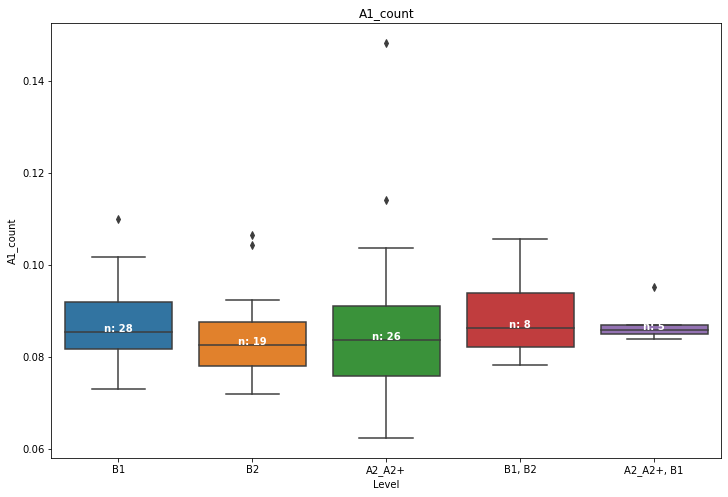

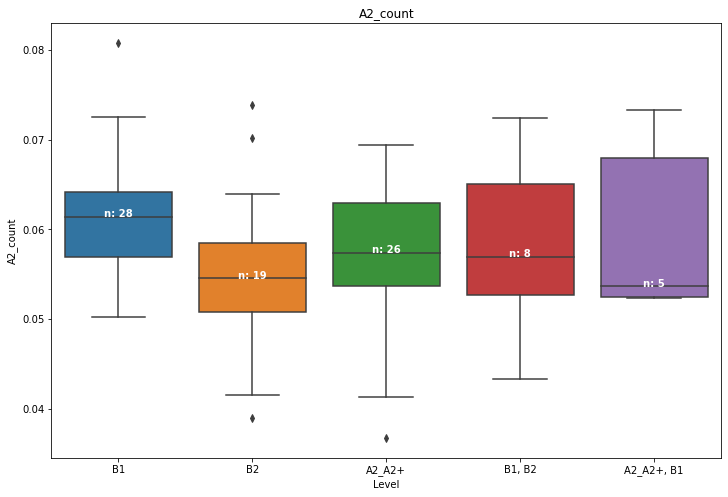

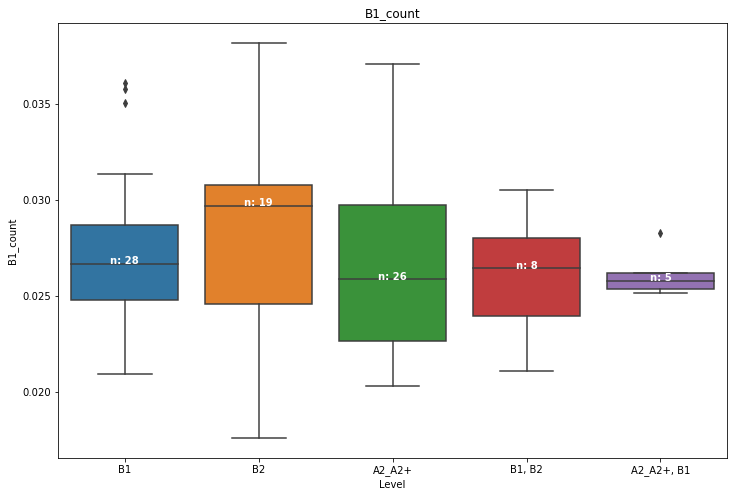

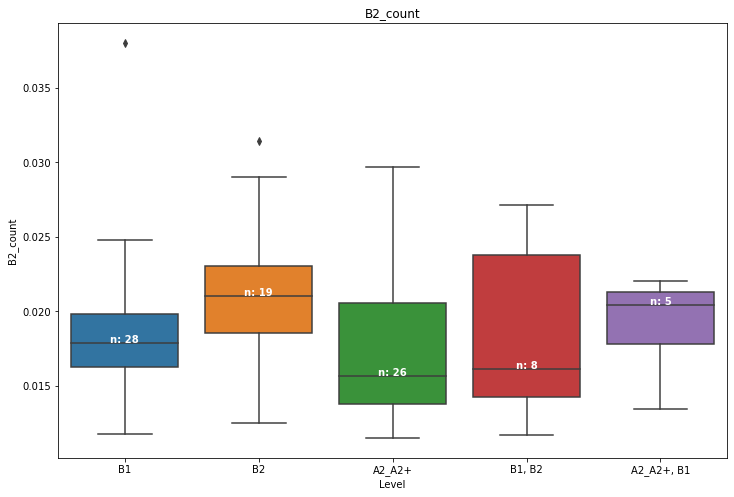

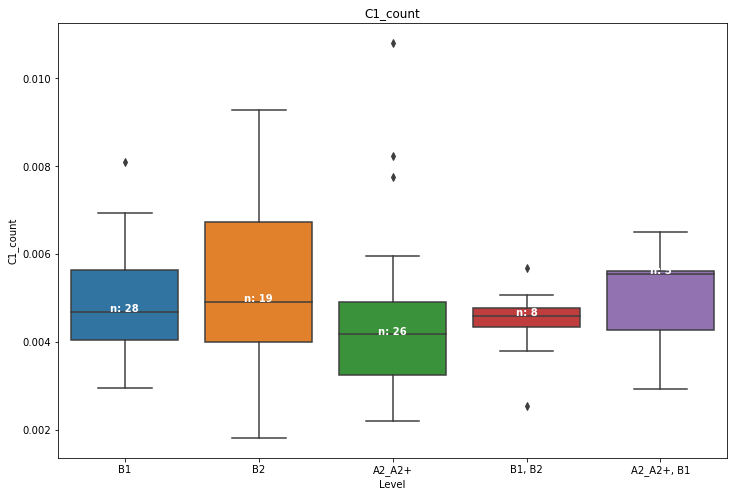

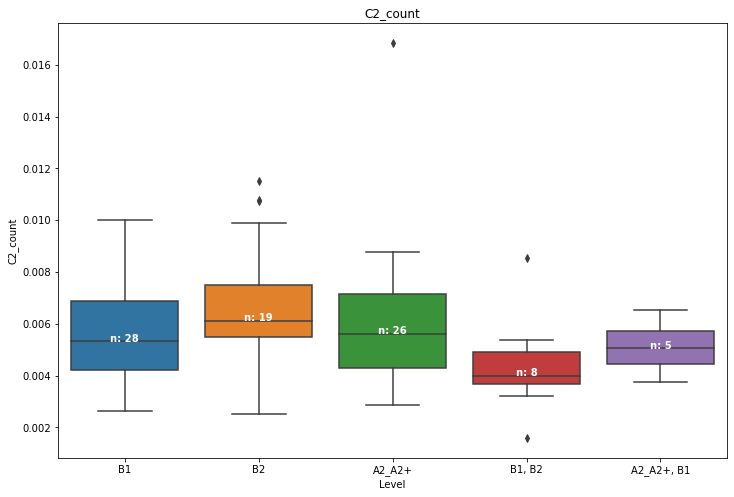

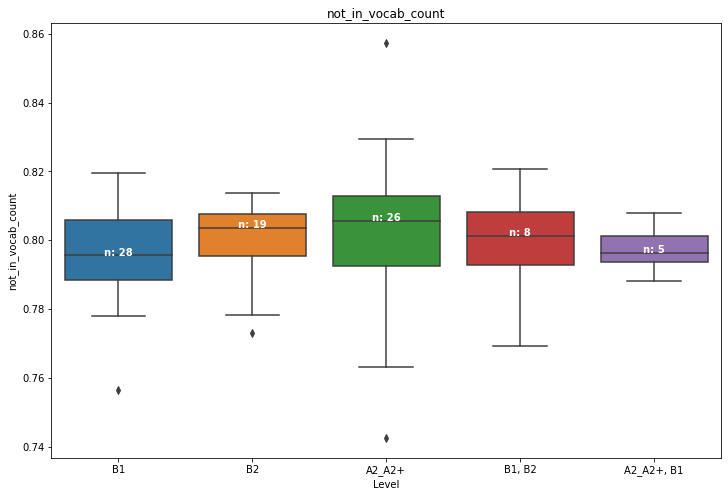

In [45]:
# Посчитаем кол-во наблюдений каждой группы
nobs = df['Level'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
# nobs

for col in ['A1_count','A2_count','B1_count','B2_count','C1_count','C2_count','not_in_vocab_count']:
    medians = df.groupby(['Level'],sort=False)[col].median().values
    # display(medians)
    # mins = df.groupby(['Level'])[col].min().min()
    # display(mins)
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(data=df,x='Level',y=col)
    ax.set_title(col)
    
    pos = range(len(nobs))

    for tick in pos:

        ax.text(pos[tick],
                medians[tick],
                nobs[tick],
                horizontalalignment='center',
                # size='x-small',
                color='w',
                weight='semibold'
               )
    
    plt.show()
    # input()


Едва ли можно визуально оценить предсказательную силу этих признаков. Здесь необходимы либо тестирование, либо оценка важности фичей уже после обучения модели.

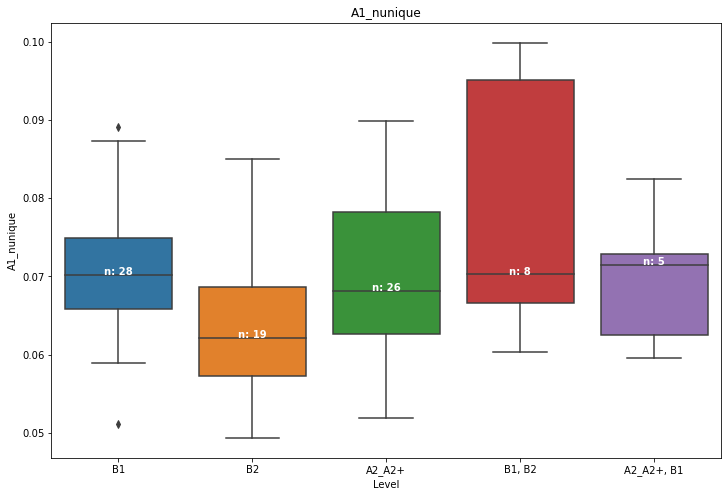

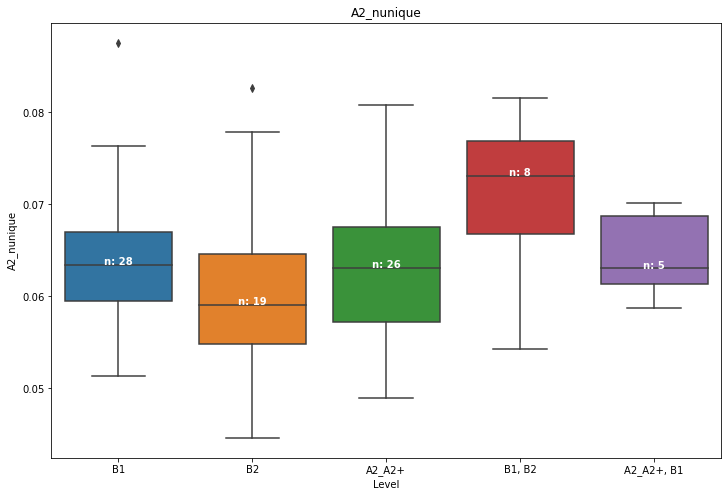

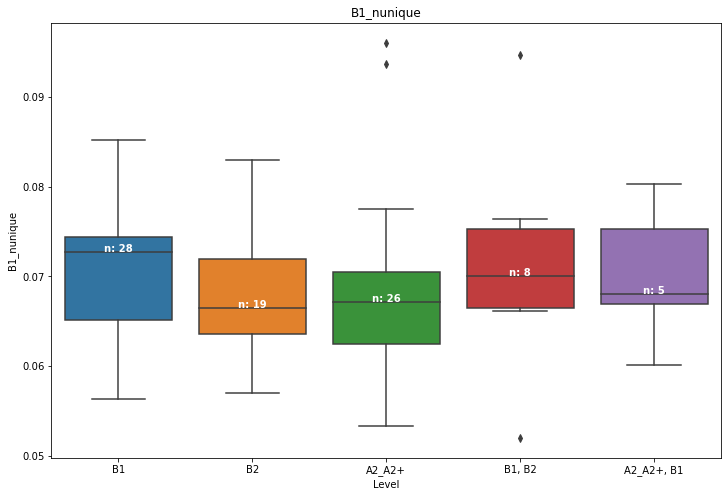

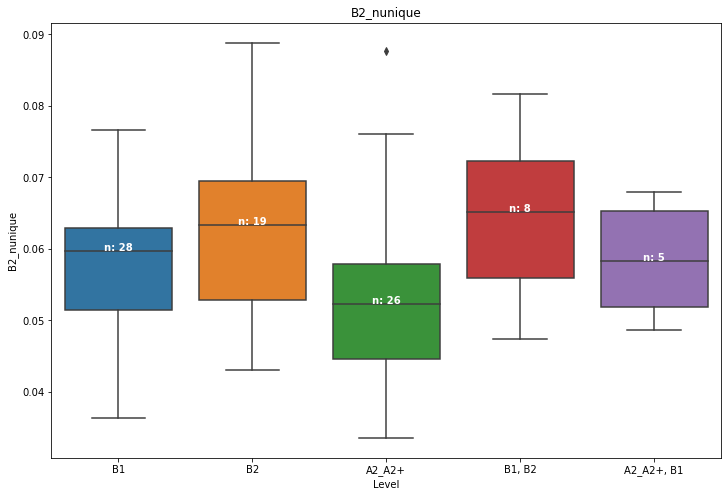

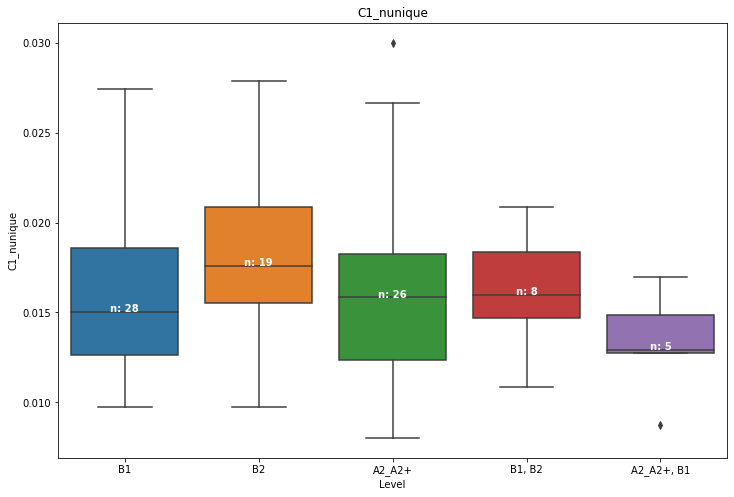

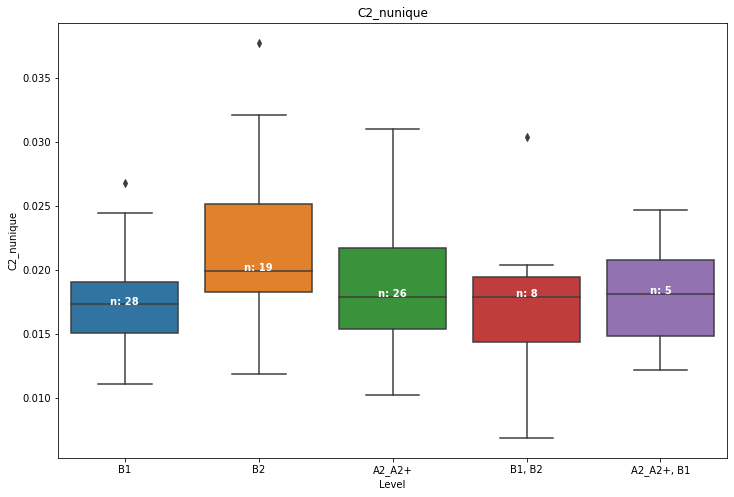

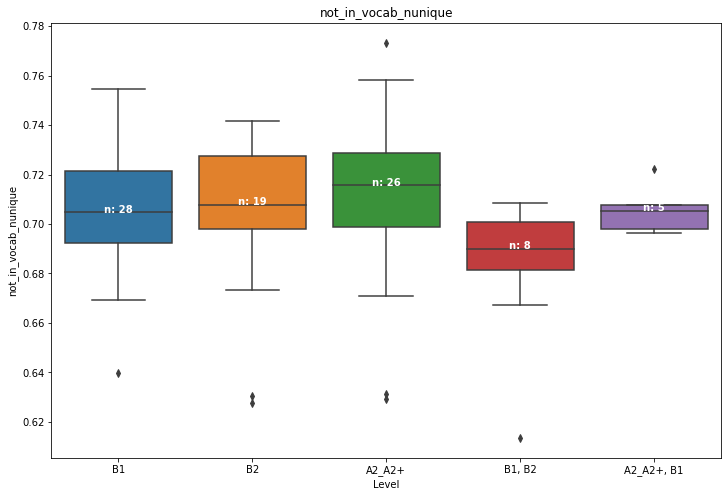

In [46]:
for col in ['A1_nunique','A2_nunique','B1_nunique','B2_nunique','C1_nunique','C2_nunique','not_in_vocab_nunique']:
    medians = df.groupby(['Level'],sort=False)[col].median().values
    # display(medians)
    # mins = df.groupby(['Level'])[col].min().min()
    # display(mins)
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(data=df,x='Level',y=col)
    ax.set_title(col)
    
    pos = range(len(nobs))

    for tick in pos:

        ax.text(pos[tick],
                medians[tick],
                nobs[tick],
                horizontalalignment='center',
                # size='x-small',
                color='w',
                weight='semibold'
               )
    
    plt.show()

# for col in ['A1_nunique','A2_nunique','B1_nunique','B2_nunique','C1_nunique','C2_nunique','not_in_vocab_nunique']:
#     sns.boxplot(data=df,x='Level',y=col).set_title(col)
#     plt.show()

По кол-ву уникальных слов тоже сложно сделать какие-то предположения о предсказательной силе признаков.

Посчитаем общее кол-во слов и уникальных в субтитрах и сравним по уровню.

In [47]:
df.head()

,Movie,Level,sub_file_name,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,not_in_vocab_count,A1_nunique,A2_nunique,B1_nunique,B2_nunique,C1_nunique,C2_nunique,not_in_vocab_nunique,word_count,word_nunique
0,10 Cloverfield Lane,B1,10_Cloverfield_lane(2016).srt,0.084858,0.057153,0.031364,0.023175,0.002962,0.008712,0.791776,0.078740,0.071850,0.082677,0.061024,0.012795,0.023622,0.669291,5739,1016
1,10 things I hate about you,B1,10_things_I_hate_about_you(1999).srt,0.082725,0.057439,0.026485,0.017330,0.004469,0.005777,0.805777,0.062901,0.051348,0.073171,0.064827,0.019897,0.024390,0.703466,9175,1558
2,A knight’s tale,B2,A_knights_tale(2001).srt,0.104305,0.038971,0.034131,0.021523,0.007132,0.005731,0.788207,0.062158,0.049180,0.066257,0.056694,0.019126,0.023907,0.722678,7852,1464
3,A star is born,B2,A_star_is_born(2018).srt,0.084999,0.070205,0.017584,0.012523,0.001817,0.002530,0.810343,0.078581,0.065369,0.062587,0.043115,0.009736,0.011822,0.728790,15412,1438
4,Aladdin,A2_A2+,Aladdin(1992).srt,0.074495,0.051981,0.037082,0.020528,0.005739,0.005960,0.804216,0.057831,0.055422,0.063253,0.060843,0.021084,0.019277,0.722289,9061,1660


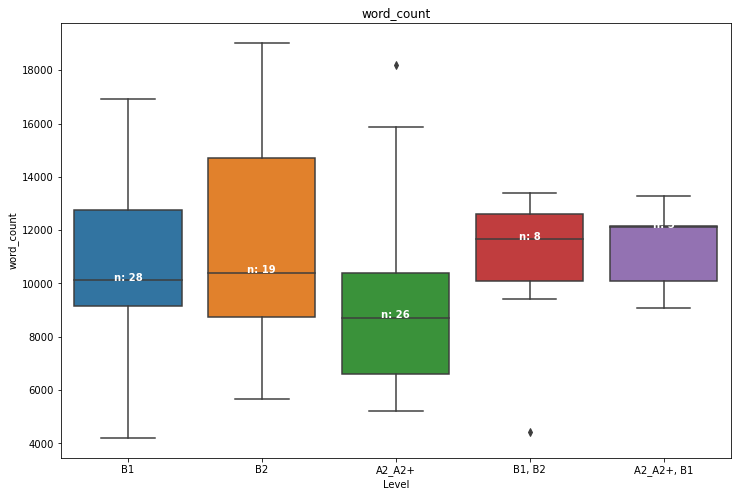

In [48]:
medians = df.groupby(['Level'],sort=False)['word_count'].median().values
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df,x='Level',y='word_count')
ax.set_title('word_count')

pos = range(len(nobs))

for tick in pos:

    ax.text(pos[tick],
            medians[tick],
            nobs[tick],
            horizontalalignment='center',
            # size='x-small',
            color='w',
            weight='semibold'
           )

plt.show()

Уровень `А2_А2+` визуально имеет меньшее кол-во слов, чем остальные уровни. А уровень `A2_A2+,B1` "не похож" на `А2_А2+`, но малое кол-во субтитров заставляет сомневаться.

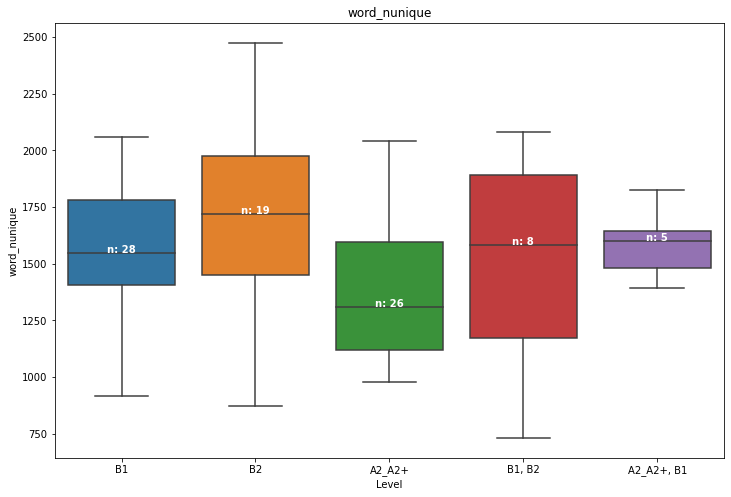

In [49]:
# plt.figure(figsize=(12,10))
# sns.boxplot(data=df,x='Level',y='word_nunique')
# plt.show()
medians = df.groupby(['Level'],sort=False)['word_nunique'].median().values
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df,x='Level',y='word_nunique')
ax.set_title('word_nunique')

pos = range(len(nobs))

for tick in pos:

    ax.text(pos[tick],
            medians[tick],
            nobs[tick],
            horizontalalignment='center',
            # size='x-small',
            color='w',
            weight='semibold'
           )

plt.show()

Здесь визуально кол-во уникальных слов вряд ли различается, кроме уровня B2. Это может являться слабым указанием на то, что действительный уровень сложности от уровня к уровню растет экспоненциально, а не линейно. Т.е. B2 это уже уровень относительно свободного владения языком там, где рост сложности начинает расти в разы.

## Обучение и сравнение моделей

Это задача классификации.

Мы можем обучать на всех классах сразу или несколько бинарных классификаций.

Целевая метрика `ROC AUC` т.к. классы несбалансированны.  
Для мультиклассов `ROC AUC ovo`, т.к. судя по [документации sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#:~:text=Insensitive%20to%20class%20imbalance%20when%20average%20%3D%3D%20%27macro%27.) one vs. one не чувствителен к дисбалансу при `average == 'macro'`

Попробуем:
- Логистическую регрессию
- Случайный лес
- Catboost
-----
  
И проверим несколько пайплайнов:

* Токенизация, лемматизация одинаковая во всех вариантах
* `sklearn.feature_extraction.text.TfidfVectorizer`
    * Вариант 1: векторизация всех данных
    * Вариант 2: Зафитить несколько объектов на каждой группе тагрета, чтобы вытащить характерный для группы набор слов (получится много фичей)
    * Вариант 3: Использовать подготовленный словарь (словарь с уровнем сложности выше)
* Кроссвалидация
-----
Возможно `catboost` потребует иной предобработки.

**Подготовим общие ф-ии**

In [50]:
def load_data_(path_to_files):
    movie_data = load_files(path_to_files,encoding='utf-8')
    X, y = movie_data.data, movie_data.target

    return X,y

# X,y = load_data_('data/Subtitles_multi_binary/B1/')
# print(len(X))
# del X,y

In [51]:
def spacy_str_preproc(text,spacy_nlp) -> str:
    text = tokenize_for_spacy(text)
    text = lemmatize_spacy(text,spacy_nlp)
    text = clean_up_for_spacy(text)
    return text

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# X = [spacy_str_preproc(sub,nlp) for sub in X]

In [52]:
def load_and_lemmatize(path_to_subs:str):
    # Загружаем данные
    X,y = load_data_(path_to_subs)
    
    # Токенизация и лемматизация
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    X = [spacy_str_preproc(sub,nlp) for sub in X]
    
    return X,y
    
#     # Применяем TF-IDF векторизацию
#     X = tfidf(X,ngram_range=(1,3),min_df=0.2)
    
#     # Считаем скор на 5 фолдах.
#     cv = cross_val_score(model,X,y,cv=5,scoring='roc_auc')
#     print(cv)


In [53]:
# Мы тут делаем этот векторайзер, который должен возвращать что?  
# Вообще тут мы делаем функции для пайплайна, значит он должен возвращать затрансформенный Х

# Какой именно вывод нам нужен? Потом эти данные идут в кроссвалидацию. Нужно ли нам возвращать датафрейм или разряженную матрицу?

def tfidf(X,ngram_range=(1,1),max_df=1.0,min_df=0,vocabulary=None):
    vectorizer = TfidfVectorizer(
                                stop_words=stopwords.words('english'),
                                ngram_range=ngram_range,
                                max_df=max_df,
                                min_df=min_df,
                                vocabulary=vocabulary
                                )
    X = vectorizer.fit_transform(X)
#     print(vectorizer.get_feature_names_out())

#     print(X.shape)
    return X
    
# tfidf(X,ngram_range=(1,3),min_df=0.2)    

### Мультиклассовая классификация

In [54]:
# Это долгая функция, поэтому запустим ее 1 раз и используем на всех вариантах мультиклассовой классификации, всех моделях
X_multi,y_multi = load_and_lemmatize('data/Subtitles_multiclass/')

**Логистическая регрессия**

1. Загружаем и лемматизируем данные
2. TFIDF (3 варианта)
3. CV на roc-auc ovo


TF-IDF на всех данных.

In [56]:


tf = TfidfVectorizer(stop_words=stopwords.words('english'),
                                ngram_range=(1,3),
                                min_df=0.2,
                                # vocabulary=vocabulary
                    )
X = tf.fit_transform(X_multi)

logreg = LogisticRegression()

logreg_multi_cv = cross_val_score(logreg,X,y_multi,cv=5,scoring='roc_auc_ovo')
print(logreg_multi_cv)

[0.46875    0.71958333 0.40125    0.69527778 0.69875   ]


In [57]:


def create_tfidf_for_each_class(X,y,**kwargs):
    X = np.array(X)
    
    class_0 = np.where(y == 0)[0]
    class_1 = np.where(y == 1)[0]
    class_2 = np.where(y == 2)[0]
    class_3 = np.where(y == 3)[0]
    class_4 = np.where(y == 4)[0]
    
    tf_0 = TfidfVectorizer(**kwargs).fit(X[class_0])
    tf_1 = TfidfVectorizer(**kwargs).fit(X[class_1])
    tf_2 = TfidfVectorizer(**kwargs).fit(X[class_2])
    tf_3 = TfidfVectorizer(**kwargs).fit(X[class_3])
    tf_4 = TfidfVectorizer(**kwargs).fit(X[class_4])
    
    return tf_0,tf_1,tf_2,tf_3,tf_4
    
# tf_0,tf_1,tf_2,tf_3,tf_4 = create_tfidf_for_each_class(X,y,
#                                                        stop_words=stopwords.words('english'),
#                                                        ngram_range=(1,3),
#                                                        max_df=0.7,
#                                                        min_df=0.3
#                                                       )

def concat_sparse_matrices_from_tfidfs(X,*args):
    result = None
    for tf in args:
        intermediate_result = tf.transform(X)
        # print(intermediate_result.shape)
        result = hstack([result,intermediate_result])
    return result
        
# X = concat_sparse_matrices_from_tfidfs(X,tf_0,tf_1,tf_2,tf_3,tf_4)

Несколько TF-IDF зафиченных на каждом классе.

In [58]:


*tfs, = create_tfidf_for_each_class(X_multi,y_multi,
                                                       stop_words=stopwords.words('english'),
                                                       ngram_range=(1,3),
                                                       max_df=0.7,
                                                       min_df=0.3
                                                      )

X = concat_sparse_matrices_from_tfidfs(X_multi,*tfs)

logreg = LogisticRegression()

logreg_multi_cv2 = cross_val_score(logreg,X,y_multi,cv=5,scoring='roc_auc_ovo')
print(logreg_multi_cv2)

[0.57       0.7625     0.40958333 0.58277778 0.6355    ]


TF-IDF со словарем.

In [59]:


tf = TfidfVectorizer(
                                # stop_words=stopwords.words('english'),
                                # ngram_range=(1,3),
                                # min_df=0.2,
                                vocabulary=vocab_for_cvect
                    )
X = tf.fit_transform(X_multi)

logreg = LogisticRegression()

logreg_multi_cv3 = cross_val_score(logreg,X,y_multi,cv=5,scoring='roc_auc_ovo')
print(logreg_multi_cv3)

[0.335      0.62291667 0.35208333 0.61416667 0.682     ]


**Случайный лес**

In [60]:


tf = TfidfVectorizer(stop_words=stopwords.words('english'),
                                ngram_range=(1,3),
                                min_df=0.2,
                                # vocabulary=vocabulary
                    )
X = tf.fit_transform(X_multi)

forest = RandomForestClassifier(class_weight='balanced')

forest_multi_cv = cross_val_score(forest,X,y_multi,cv=5,scoring='roc_auc_ovo')
print(forest_multi_cv)

[0.41333333 0.67166667 0.325      0.63805556 0.49475   ]


In [61]:


*tfs, = create_tfidf_for_each_class(X_multi,y_multi,
                                                       stop_words=stopwords.words('english'),
                                                       ngram_range=(1,3),
                                                       max_df=0.7,
                                                       min_df=0.3
                                                      )

X = concat_sparse_matrices_from_tfidfs(X_multi,*tfs)

forest = RandomForestClassifier(class_weight='balanced')

forest_multi_cv2 = cross_val_score(forest,X,y_multi,cv=5,scoring='roc_auc_ovo')
print(forest_multi_cv2)

[0.57854167 0.685625   0.326875   0.53333333 0.62125   ]


In [62]:


tf = TfidfVectorizer(
                                # stop_words=stopwords.words('english'),
                                # ngram_range=(1,3),
                                # min_df=0.2,
                                vocabulary=vocab_for_cvect
                    )
X = tf.fit_transform(X_multi)

forest = RandomForestClassifier(class_weight='balanced')

forest_multi_cv3 = cross_val_score(forest,X,y_multi,cv=5,scoring='roc_auc_ovo')
print(forest_multi_cv3)

[0.47354167 0.6        0.51229167 0.57875    0.6325    ]


**Catboost `[UNDONE]`**

In [63]:
# from catboost import Pool, CatBoostClassifier
# from catboost import cv as catboost_cv

# catboost_pool = Pool(X_multi,y_multi,text_features=[0])

# params = {
#     'loss_function': 'MultiClass',
#     # 'iterations': 100,
#     # 'custom_loss': 'AUC:type=Mu;hints=skip_train~false',
#     # 'custom_loss': 'AUC',
#     # 'learning_rate': 0.5,
#     'text_features': [0],
#     # plot=True,
#     # stratified=False,
#     'verbose': False
# }

# catboost_model = CatBoostClassifier(**params)
# catboost_multi_cv = cross_val_score(catboost_model,X_multi,y_multi,cv=5,scoring='roc_auc_ovo')
# print(catboost_multi_cv)

In [64]:
# def print_cv_summary(cv_data):
#     cv_data.head(10)

#     best_value = cv_data['test-Logloss-mean'].min()
#     best_iter = cv_data['test-Logloss-mean'].values.argmin()

#     print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
#         best_value,
#         cv_data['test-Logloss-std'][best_iter],
#         best_iter)
#     )

**Сравнение мультиклассовых моделей**

In [65]:
roc_auc_ovo_scores = pd.DataFrame()
for name,data in {'logreg1':logreg_multi_cv,
             'logreg2':logreg_multi_cv2,
             'logreg3':logreg_multi_cv3,
             'forest1':forest_multi_cv,
             'forest2':forest_multi_cv2,
             'forest3':forest_multi_cv3}.items():
    data = pd.DataFrame(data,columns=[name],index=[1,2,3,4,5]).T
    roc_auc_ovo_scores = pd.concat([roc_auc_ovo_scores,data],axis=0)
    
roc_auc_ovo_scores['mean'] = roc_auc_ovo_scores.mean(axis=1)
roc_auc_ovo_scores['std'] = roc_auc_ovo_scores.std(axis=1)
roc_auc_ovo_scores

,1,2,3,4,5,mean,std
logreg1,0.468750,0.719583,0.401250,0.695278,0.69875,0.596722,0.134018
logreg2,0.570000,0.762500,0.409583,0.582778,0.63550,0.592072,0.113848
logreg3,0.335000,0.622917,0.352083,0.614167,0.68200,0.521233,0.147049
forest1,0.413333,0.671667,0.325000,0.638056,0.49475,0.508561,0.131397
forest2,0.578542,0.685625,0.326875,0.533333,0.62125,0.549125,0.121938
forest3,0.473542,0.600000,0.512292,0.578750,0.63250,0.559417,0.058236


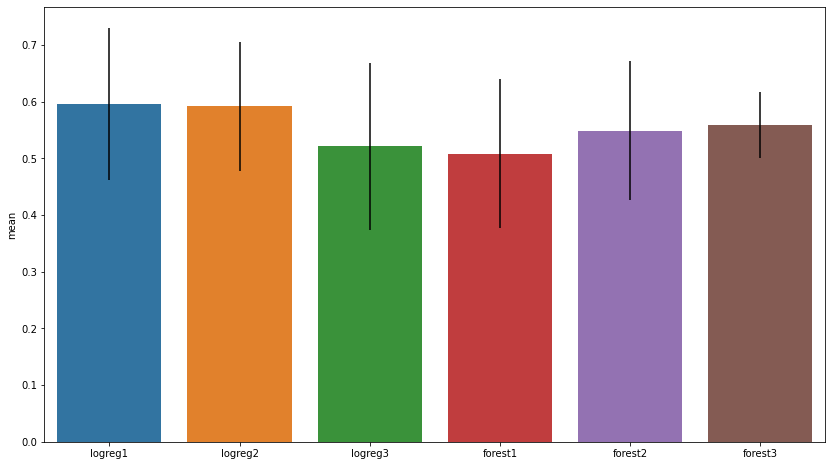

In [66]:
plt.figure(figsize=(14, 8))
sns.barplot(x=roc_auc_ovo_scores.index, y='mean', yerr=roc_auc_ovo_scores['std'], data=roc_auc_ovo_scores)
plt.show()

Во всех случаях модели не всегда предсказывают лучше, чем случайное предсказание (0.5).  
Это никуда не годиться.

### Мульти-бинарная классификация

In [67]:
levels = os.listdir('data/Subtitles_multi_binary/')

In [68]:
params = {
        'loss_function': 'Logloss',
        # 'iterations': 100,
        # 'custom_loss': 'AUC:type=Mu;hints=skip_train~false',
        # 'custom_loss': 'AUC',
        # 'learning_rate': 0.5,
        'text_features': [0],
        # plot=True,
        # stratified=False,
        'verbose': False
        }


roc_auc_multi_binary_score = pd.DataFrame()

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
for level in levels:
    pwd = os.path.abspath(os.getcwd())
    path_to_level = os.path.join(pwd,r'data\Subtitles_multi_binary')
    path_to_level = os.path.join(path_to_level, level)
    print(level)
    # print('Path to level:')
    # print(path_to_level)
    # pipeline_(path_to_level)
    X_raw,y = load_and_lemmatize(path_to_level)



#     logreg,forest,catboost tfidf all data
    logreg = LogisticRegression()
    forest = RandomForestClassifier(class_weight='balanced')
    # catboost_model = CatBoostClassifier(**params)
    
    tf = TfidfVectorizer(stop_words=stopwords.words('english'),
                                ngram_range=(1,3),
                                min_df=0.2,
                                # vocabulary=vocabulary
                    )
    X = tf.fit_transform(X_raw)
    logreg_1 = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
    forest_1 = cross_val_score(forest,X,y,cv=5,scoring='roc_auc')
    # catboost_1 = cross_val_score(catboost_model,pd.DataFrame(X.todense()),y,cv=5,scoring='roc_auc')
    
#     logreg,forest,catboost tfidf on class 1 only
    logreg = LogisticRegression()
    forest = RandomForestClassifier(class_weight='balanced')
    # catboost_model = CatBoostClassifier(**params)
    
    def create_tfidf_for_0_class(X,y,**kwargs):
        X = np.array(X)

        class_0 = np.where(y == 0)[0]
        tf_0 = TfidfVectorizer(**kwargs).fit(X[class_0])
        return tf_0
    
    tf = create_tfidf_for_0_class(X_raw,y,
                                   stop_words=stopwords.words('english'),
                                   ngram_range=(1,3),
                                   min_df=0.2
                                 )
    X = tf.transform(X_raw)

    logreg_2 = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
    forest_2 = cross_val_score(forest,X,y,cv=5,scoring='roc_auc')
    # catboost_2 = cross_val_score(catboost_model,pd.DataFrame(X.todense()),y,cv=5,scoring='roc_auc')
    
    # logreg,forest,catboost tfidf with vocab
    logreg = LogisticRegression()
    forest = RandomForestClassifier(class_weight='balanced')
    # catboost_model = CatBoostClassifier(**params)
    
    tf = TfidfVectorizer(
                        # stop_words=stopwords.words('english'),
                        # ngram_range=(1,3),
                        # min_df=0.2,
                        vocabulary=vocab_for_cvect
                        )
    X = tf.fit_transform(X_raw)


    logreg_3 = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
    forest_3 = cross_val_score(forest,X,y,cv=5,scoring='roc_auc')
    # catboost_3 = cross_val_score(catboost_model,pd.DataFrame(X.todense()),y,cv=5,scoring='roc_auc')


    intermediate_score = pd.DataFrame()
    for name,data in {'logreg1':logreg_1,
                     'logreg2':logreg_2,
                     'logreg3':logreg_3,
                     'forest1':forest_1,
                     'forest2':forest_2,
                     'forest3':forest_3,
                     # 'catboost1':catboost_1,
                     # 'catboost2':catboost_2,
                     # 'catboost3':catboost_3
                     }.items():
        data = pd.DataFrame(data,columns=[name],index=[1,2,3,4,5]).T
        intermediate_score = pd.concat([intermediate_score,data],axis=0)
    
    intermediate_score['mean'] = intermediate_score.mean(axis=1)
    intermediate_score['std'] = intermediate_score.std(axis=1)
    intermediate_score['level'] = level
    intermediate_score['n_0'] = pd.Series(y).value_counts().loc[0]
    
    roc_auc_multi_binary_score = pd.concat([roc_auc_multi_binary_score,intermediate_score],axis=0)
    # display(roc_auc_multi_binary_score)
        

roc_auc_multi_binary_score
    

A2_A2+
A2_A2+, B1
B1
B1, B2
B2


,1,2,3,4,5,mean,std,level,n_0
logreg1,0.402778,0.883333,0.533333,0.650000,0.766667,0.647222,0.168966,A2_A2+,26
logreg2,0.416667,0.900000,0.600000,0.716667,0.783333,0.683333,0.164992,A2_A2+,26
logreg3,0.430556,0.800000,0.466667,0.650000,0.866667,0.642778,0.173753,A2_A2+,26
forest1,0.520833,0.733333,0.491667,0.716667,0.725000,0.637500,0.107690,A2_A2+,26
forest2,0.534722,0.766667,0.500000,0.833333,0.775000,0.681944,0.136773,A2_A2+,26
forest3,0.694444,0.758333,0.316667,0.650000,0.891667,0.662222,0.191038,A2_A2+,26
logreg1,0.705882,0.937500,0.500000,0.375000,0.562500,0.616176,0.192790,"A2_A2+, B1",5
logreg2,1.000000,0.875000,0.937500,0.937500,0.937500,0.937500,0.039528,"A2_A2+, B1",5
logreg3,0.529412,0.250000,0.250000,0.937500,0.125000,0.418382,0.291407,"A2_A2+, B1",5
forest1,0.647059,0.937500,0.906250,0.000000,0.468750,0.591912,0.342581,"A2_A2+, B1",5


In [69]:
roc_auc_multi_binary_score = roc_auc_multi_binary_score.reset_index()

In [70]:
roc_auc_multi_binary_score['level_n'] = roc_auc_multi_binary_score['level'] + ' n=' + roc_auc_multi_binary_score['n_0'].apply(str)

In [71]:
roc_auc_multi_binary_score.head()

,index,1,2,3,4,5,mean,std,level,n_0,level_n
0,logreg1,0.402778,0.883333,0.533333,0.650000,0.766667,0.647222,0.168966,A2_A2+,26,A2_A2+ n=26
1,logreg2,0.416667,0.900000,0.600000,0.716667,0.783333,0.683333,0.164992,A2_A2+,26,A2_A2+ n=26
2,logreg3,0.430556,0.800000,0.466667,0.650000,0.866667,0.642778,0.173753,A2_A2+,26,A2_A2+ n=26
3,forest1,0.520833,0.733333,0.491667,0.716667,0.725000,0.637500,0.107690,A2_A2+,26,A2_A2+ n=26
4,forest2,0.534722,0.766667,0.500000,0.833333,0.775000,0.681944,0.136773,A2_A2+,26,A2_A2+ n=26


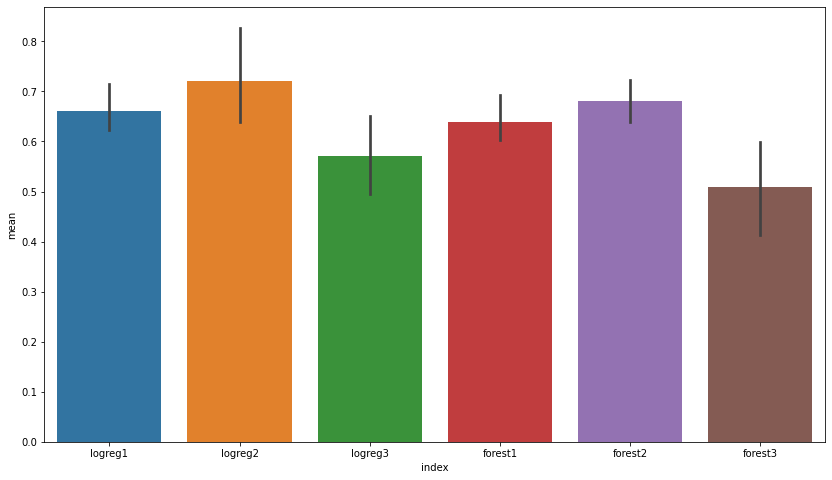

In [72]:
plt.figure(figsize=(14, 8))
sns.barplot(data=roc_auc_multi_binary_score,x='index',y='mean')
plt.legend([],[], frameon=False)
plt.show()

Видим, что лучше всего себя показывает логистическая регрессия с TfidfVectorizer зафиченными только на 0 классе (классе конкретного уровня).  
И в целом `ROC AUC` у многих моделей **выше**, чем у мультиклассовых.

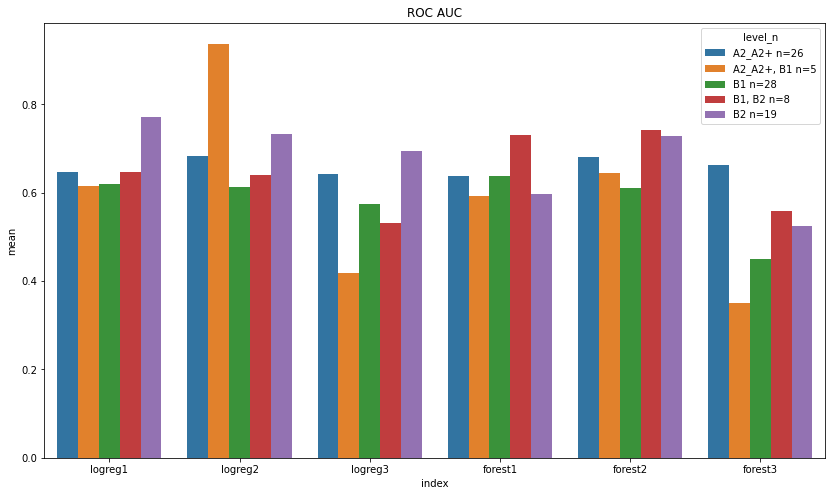

In [73]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=roc_auc_multi_binary_score,x='index',y='mean',hue='level_n')#,yerr=roc_auc_multi_binary_score['std'],hue='level')
ax.set_title('ROC AUC')
# plt.legend([],[], frameon=False)

plt.show()

## Итог

**Задача**: сделать модель оценивающую уровень сложности английского языка в фильме по субтитрам.

При этом предсказывать необходимо не все уровни, а только `A2`,`B1`,`B2`, т.к. для уровня `A1` доступны только специальные обучающие фильмы, а для `C1`,`C2` нет необходимости оценивать сложность, т.к. уровень достаточный, чтобы понимать почти все.

**Результат неудовлетворительный**

* CEFR уровни английского языка не определяются по формальным признакам
* Существуют научные работы старающиеся определить такие формальные признаки, но в конечном счете много разночтений
* Уже существуют готовые модели, которые достаточно хорошо предсказывающие уровень сложности ***текста*** [ссылка](https://github.com/AMontgomerie/CEFR-English-Level-Predictor) Эта модель достаточно хорошо справляется и с нашей задачей.

-----------
* Основные проблемы в данной работе находятся в разметке
* Субтитры принадлежащие сразу уровням `A2_A2+`, `B1` и также `B1`, `B2` являются оценкой разных специалистов.
* Мы можем вытащить информацию только из субтитров, а оценка скорее всего учитывала и другие факторы извлекаемые, например, из аудио источника
* Стоит ли пытаться обучать модель на субтитрах, но по таргету, который включает в себя аудио - я сомневаюсь. Возможно, это указание на переформулирование задачи - создание отдельных моделей для аудио и субтитров.
* Можно скормить аудио поток speech recognizer-у, результат распознавания сравнить с субтитрами и возвращать какую-то долю ошибок, по которой предполагать о сложности восприятия на слух.
* Можно больше времени уделить предобработке словаря, т.к. это ценный и заслуживающий доверия источник. Может ли благодаря такому словарю задача превратиться в алгоритмическую?
